In [23]:
import transformers
assert transformers.__version__ >= '4.17.'

import os 
import re
import numpy as np 
import random
import pandas as pd
import preprocessor
import torch 
import shutil
import yaml
from transformers import (
    AutoTokenizer, 
    AutoModel , 
    AdamW, get_linear_schedule_with_warmup)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from torch import Tensor 
from torch.utils.data import Dataset, DataLoader
from attrdict import AttrDict

assert torch.cuda.is_available()
tqdm.pandas()

input_dir = '../inputs'
output_dir = '../outputs'

project_name = 'go-emotion-tiny'

with open('../config/{}.yaml'.format(project_name), 'r') as f:
    args = AttrDict(yaml.safe_load(f))

def init_seed(seed:int):
  torch.manual_seed(seed)
  random.seed(seed)
  np.random.seed(seed)
  return

init_seed(args.seed)

In [24]:
# utility functions
re_number = re.compile('[0-9]+')
re_url = re.compile("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+")
re_tag = re.compile('\[[A-Z]+\]')
re_char = re.compile('[^0-9a-zA-Z\s?!.,:\'\"//]+')
re_char_clean = re.compile('[^0-9a-zA-Z\s?!.,\[\]]')
re_punc = re.compile('[?!,.\'\"]')




def _word_mapper(text:str, mapper:dict):
    for word in text.split(' '):
        if word in mapper:
            text = text.replace(word, mapper[word])
    return text


def _char_mapper(text:str, mapper:dict):
    for k, v  in mapper.items():
        text = text.replace(k, v)
    return text


def clean_text(text:str, mapChar:dict, mapC:dict, mapS:dict):
    """
        text:
        mapChar: character mapper
        mapC: contraction mapper
        mapS: spelling mistake mapper
    """
    text = re.sub(re_char, "", text) # Remove unknown character
    text = _char_mapper(text, mapChar) # Similar characters mapping
    text = _word_mapper(text, mapC) # Remove contraction
    text = _word_mapper(text, mapS) # Remove spelling mistakes

    text = re.sub(re_number, ' [number] ', text) # Replace number with tag
    text = re.sub(re_url, ' [url] ', text) # Replace URL with number

    text = re.sub(re_punc, lambda a: f" {a.group(0)} ", text) # Add space between punctuation
    text = preprocessor.clean(text) # Remove tweet clean

    text = re.sub(re_char_clean, "", text) # Only alphanumeric and punctuations.
    text = text.lower() # Lower text
    text = " ".join([w for w in text.split(' ') if w != " "]) # Remove whitespace

    return text


In [5]:
def init_seed(args):
  torch.manual_seed(args.seed)
  random.seed(args.seed)
  np.random.seed(args.seed)
  return

init_seed(args)

In [6]:
# load dataset
D = pd.read_csv(args.dataset_source_path)
D.head(3)

,id,text,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,eew5j0j,That game hurt.,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,eemcysk,>sexuality shouldn’t be a grouping category I...,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ed2mah1,"You do right, if you don't care then fuck 'em!",False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [7]:
# common spelling mistakes. 
S = pd.read_csv(os.path.join(input_dir, 'spelling', 'aspell.txt'), sep=":",names=["correction","misspell"])
S['misspell'] = S['misspell'].str.strip()
S['misspell'] = S['misspell'].str.split(' ')
S = S.explode('misspell').reset_index(drop=True)
S = S.drop_duplicates('misspell')
S.head(3)

,correction,misspell
0,Nevada,nevade
1,Presbyterian,presbyterian
2,RSX,rsx


In [8]:
# replacing constraction i.e. shoudn't => shoud not
C = pd.read_csv(os.path.join(input_dir, 'contractions', 'contractions.csv'))
C.columns = ['contraction', 'meaning']
C = C[['meaning', 'contraction']]
C.head(3)

,meaning,contraction
0,alright,'aight
1,is not,ain't
2,am not,amn't


In [9]:
mapChar = {
    '’': '\''
}
mapC = dict(zip(C['contraction'], C['meaning']))
mapS = dict(zip(S['misspell'], S['correction']))
punctuations = '''()-[]{};:'"\,<>./@#$%^&_~'''
mapP = dict(zip(list(punctuations), [""] * len(punctuations)))

def word_mapper(text, mapper):
    for word in text.split(' '):
        if word in mapper:
            text = text.replace(word, mapper[word])
    return text

def char_mapper(text, mapper):
    for k, v  in mapper.items():
        text = text.replace(k, v)
    return text

In [10]:
re_number = re.compile('[0-9]+')
re_url = re.compile("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+")
re_tag = re.compile('\[[A-Z]+\]')
re_char = re.compile('[^0-9a-zA-Z\s?!.,:\'\"//]+')
re_char_clean = re.compile('[^0-9a-zA-Z\s?!.,\[\]]')
re_punc = re.compile('[?!,.\'\"]')

def clean_text(text):
    text = re.sub(re_char, "", text) # Remove unknown character
    text = char_mapper(text, mapChar) # Similar characters mapping
    text = word_mapper(text, mapC) # Remove contraction
    text = word_mapper(text, mapS) # Remove spelling mistakes

    text = re.sub(re_number, ' [number] ', text) # Replace number with tag
    text = re.sub(re_url, ' [url] ', text) # Replace URL with number

    text = re.sub(re_punc, lambda a: f" {a.group(0)} ", text) # Add space between punctuation
    text = preprocessor.clean(text) # Remove tweet clean

    text = re.sub(re_char_clean, "", text) # Only alphanumeric and punctuations.
    text = text.lower() # Lower text
    text = " ".join([w for w in text.split(' ') if w != " "]) # Remove whitespace

    return text

In [ ]:
def prepare_split_data(
    dataset_source_path, 
    train_dataset_path, 
    test_dataset_path, 
    emotions, 
    drop_insignifiant=False, 
    test_split=0.2, 
    seed=0, 
):
  emotions = list(emotions)
  data = pd.read_csv(dataset_source_path)
  data['text'] = data['text'].progress_apply(clean_text)
  data = data[data['text'] != '']
  data = data[['text'] + list(emotions)]

  if drop_insignifiant:
    data = data[data[list(emotions)].sum(1) > 0].reset_index(drop=True)

  train, test = train_test_split(data, 
                                 test_size=test_split, 
                                 shuffle=True, 
                                 random_state=seed)
  
  train.to_csv(train_dataset_path, index=None)
  test.to_csv(test_dataset_path, index=None)
  return

prepare_split_data(
    args.dataset_source_path, 
    args.train_dataset_path, 
    args.test_dataset_path, 
    args.emotions, 
    args.drop_insignifiant, 
    args.test_split, 
    args.seed
)

In [12]:
if 'D' in globals():
  del D

Dtr = pd.read_csv(args.train_dataset_path)
Dtr.head(3)

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise
0,"oh yah , no worries . i appreciate your time a...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"name just has the runs . don t worry , name i...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,"it s the donuts done brought ya back , is not...",0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
tokenizer = AutoTokenizer.from_pretrained(args.encoder_name)
encoder = AutoModel.from_pretrained(args.encoder_name)

def tokenizing_input(texts, tokenizer, maxlen=50):
    result = tokenizer.batch_encode_plus(
            texts, 
          return_attention_mask=True, 
        return_token_type_ids=False,
        padding='longest', 
        max_length=maxlen)
    return result['input_ids'], result['attention_mask']

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
class ZipDataset(Dataset):
  def __init__(self, datasets):
    super(ZipDataset, self).__init__()
    self.keys = list(datasets.keys())
    self.values = list(datasets.values()) 
    self.datasets = datasets
    assert all([len(self.values[0]) == len(v) for v in self.values])

  def __len__(self):
    return len(self.values[0])
  
  def __getitem__(self, idx):
    item = {}
    for k, v in self.datasets.items():
      item[k] = v[idx]
    return item

def generate_dataset(args, tokenizer):
  Dtr = pd.read_csv(args.train_dataset_path)
  X = Dtr['text'].to_numpy()
  y = Dtr[list(args.emotions)].to_numpy()

  Xtr, Xval, ytr, yval = train_test_split(X, y, 
                                          test_size=args.validation_split_from_train, 
                                          shuffle=False)

  Xtr_tk, Xtr_mask= tokenizing_input(Xtr.tolist(), tokenizer, 
                                     maxlen=args.sentence_max_len)
  Xval_tk, Xval_mask = tokenizing_input(Xval.tolist(), tokenizer, 
                                        maxlen=args.sentence_max_len)

  train_dataset = ZipDataset({
      'input_ids': Tensor(Xtr_tk).type(torch.int32), 
      'attention_mask': Tensor(Xtr_mask).type(torch.int32), 
      'y_true': Tensor(ytr).type(torch.float32)
  })

  val_dataset = ZipDataset({
      'input_ids': Tensor(Xval_tk).type(torch.int32), 
      'attention_mask': Tensor(Xval_mask).type(torch.int32), 
      'y_true': Tensor(yval).type(torch.float32)
  })

  return train_dataset, val_dataset

In [15]:
%%time
train_dataset, val_dataset = generate_dataset(args, tokenizer)

Wall time: 7.06 s


In [16]:
def compute_classification_metrics(y_true, proba, threshold):
  assert len(y_true) == len(proba), 'y_true and y_pred length mismatch {} {}'.format(len(preds), len(labels))

  results = {}
  y_true = y_true.astype(int)
  y_pred = (proba >= threshold).astype(int)

  results["accuracy"] = (y_true == y_pred).mean()
  if (np.unique(y_true) == 1).sum() == 0:
    results["auc_roc_macro"] = roc_auc_score(y_true, proba, average='macro')
    results["auc_roc_micro"] = roc_auc_score(y_true, proba, average='micro')
  results["macro_precision"], results["macro_recall"], results["macro_f1"], _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
  results["micro_precision"], results["micro_recall"], results["micro_f1"], _ = precision_recall_fscore_support(y_true, y_pred, average="micro")
  results["weighted_precision"], results["weighted_recall"], results["weighted_f1"], _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

  return results

In [20]:
class GoEmotionClassiferWithGRU(torch.nn.Module):
  def __init__(self, 
               encoder,
               encoder_dim=128, 
               seq_len=82,
               rnn_hidden = 50,  
               rnn_num_layers = 1,
               bidirectional=True, 
               hiddens = None,
               dropout_p=0.1, 
               n_cls:int = 28, 
               criterion = torch.nn.BCEWithLogitsLoss()
               ):
    super(GoEmotionClassiferWithGRU, self).__init__()

    self.encoder_dim = encoder_dim
    self.rnn_hidden = rnn_hidden
    self.rnn_num_layers = rnn_num_layers
    self.seq_len = seq_len
    self.bidirectional = bidirectional
    self.hiddens = [100] if hiddens is None else hiddens 
    self.dropout_p = dropout_p 
    self.n_cls = n_cls
    self.criterion = criterion

    # layers
    self.encoder = encoder
    self.gru = torch.nn.GRU(
        input_size= encoder_dim, 
        hidden_size = rnn_hidden, 
        batch_first = True, 
        bidirectional = bidirectional
    )
    self.dropout = torch.nn.Dropout(dropout_p)

    # full connected
    fcs = []
    in_feature = (int(bidirectional) + 1) * rnn_hidden
    for h in self.hiddens:
      fcs.append(torch.nn.Linear(in_feature, h))
      fcs.append(torch.nn.ReLU())
      in_feature = h    
    fcs.append(torch.nn.Linear(in_feature, n_cls))
    self.fcs = torch.nn.Sequential(*fcs)

  def forward(self, X_tk, X_mask, y_true=None):
    encoder_output = self.encoder(X_tk, X_mask)
    contextual_emb = encoder_output['last_hidden_state'] # contextual embedding
    output, _ = self.gru(contextual_emb)
    output = output[:, -1, :]
    z = self.dropout(output) 
    logits = self.fcs(z)

    if not (y_true is None):
      loss = self.criterion(logits, y_true)
      return (loss, logits)
    return logits

  def save_pretrained(self, path):
    encoder_path = os.path.join(path, 'encoder')
    pt_path = os.path.join(path, 'model.pt')
    encoder = self.encoder
    encoder.save_pretrained(encoder_path)
    self.encoder = None
    torch.save({
        'model': self.state_dict(), 
        'config': {
            'encoder': encoder.config.to_dict(), 
            'criterion': self.criterion.__class__.__name__, 
            'architecture': str(self), 
            'rnn_hidden': self.rnn_hidden,
            'rnn_num_layers': self.rnn_num_layers,
            'seq_len': self.seq_len,
            'bidirectional': self.bidirectional,
            'hiddens': self.hiddens, 
            'dropout_p': self.dropout_p, 
            'n_cls': self.n_cls
        }
    }, pt_path)
    self.encoder = encoder
    return

  @classmethod
  def from_pretrained(cls, path):
    pt_path = os.path.join(path, 'model.pt')
    encoder_path = os.path.join(path, 'encoder')
    saved_model = torch.load(pt_path, map_location=torch.device('cpu'))
    encoder = AutoModel.from_pretrained(encoder_path)
    model = cls(
        encoder=None,
        encoder_dim = saved_model['config']['encoder']['hidden_size'], 
        seq_len = saved_model['config']['seq_len'],
        rnn_hidden = saved_model['config']['rnn_hidden'],  
        rnn_num_layers = saved_model['config']['rnn_num_layers'],
        bidirectional= saved_model['config']['bidirectional'], 
        hiddens = saved_model['config']['hiddens'],
        dropout_p = saved_model['config']['dropout_p'],
        n_cls = saved_model['config']['n_cls'],
        criterion = getattr(torch.nn, saved_model['config']['criterion'])()
    )
    model.load_state_dict(saved_model['model'])
    model.encoder = encoder
    return model 

class GoEmotionClassifer(torch.nn.Module):
  def __init__(self, 
               encoder,
               encoder_dim=128, 
               hiddens = None,
               dropout_p=0.1, 
               n_cls:int = 28, 
               criterion = torch.nn.BCEWithLogitsLoss()
               ):
    super(GoEmotionClassifer, self).__init__()

    self.encoder_dim = encoder_dim
    self.hiddens = [100] if hiddens is None else hiddens 
    self.dropout_p = dropout_p 
    self.n_cls = n_cls
    self.criterion = criterion

    # layers
    self.encoder = encoder
    self.dropout = torch.nn.Dropout(dropout_p)

    # full connected
    fcs = []
    in_feature = encoder_dim 
    for h in self.hiddens:
      fcs.append(torch.nn.Linear(in_feature, h))
      fcs.append(torch.nn.ReLU())
      in_feature = h    
    fcs.append(torch.nn.Linear(in_feature, n_cls))
    self.fcs = torch.nn.Sequential(*fcs)

  def forward(self, X_tk, X_mask, y_true=None):
    encoder_output = self.encoder(X_tk, X_mask) # contextual embedding
    pooled_output = encoder_output['pooler_output'] 
    z = self.dropout(pooled_output) 
    logits = self.fcs(z)

    if not (y_true is None):
      loss = self.criterion(logits, y_true)
      return (loss, logits)
    return logits

  def save_pretrained(self, path):
    encoder_path = os.path.join(path, 'encoder')
    pt_path = os.path.join(path, 'model.pt')
    encoder = self.encoder
    encoder.save_pretrained(encoder_path)
    self.encoder = None
    torch.save({
        'model': self.state_dict(), 
        'config': {
            'encoder': encoder.config.to_dict(), 
            'criterion': self.criterion.__class__.__name__, 
            'architecture': str(self), 
            'hiddens': self.hiddens, 
            'dropout_p': self.dropout_p, 
            'n_cls': self.n_cls
        }
    }, pt_path)
    self.encoder = encoder
    return

  @classmethod
  def from_pretrained(cls, path):
    pt_path = os.path.join(path, 'model.pt')
    encoder_path = os.path.join(path, 'encoder')
    saved_model = torch.load(pt_path, map_location=torch.device('cpu'))
    encoder = AutoModel.from_pretrained(encoder_path)
    model = cls(
        encoder=None,
        encoder_dim = saved_model['config']['encoder']['hidden_size'], 
        hiddens = saved_model['config']['hiddens'],
        dropout_p = saved_model['config']['dropout_p'],
        n_cls = saved_model['config']['n_cls'],
        criterion = getattr(torch.nn, saved_model['config']['criterion'])()
    )
    model.load_state_dict(saved_model['model'])
    model.encoder = encoder
    return model 


In [21]:
def proba_on_examples(X, model, tokenizer=None):
  if tokenizer is not None:
    X_tk, X_mask = tokenizing_input(X, tokenizer)
    X_tk = torch.Tensor(X_tk).type(torch.int32)
    X_mask = torch.Tensor(X_mask).type(torch.int32)
  else:
    X_tk, X_mask = X['input_ids'], X['attention_mask']

  with torch.no_grad():
    logits = model(X_tk, X_mask).numpy()
    proba = 1 / (1 + np.exp(-logits))
    
  return proba

def proba_to_emotion(proba, threshold, emotions):
  assert proba.shape[-1] == len(emotions), 'emotions and proba mismatch {} vs {}'.format(len(emotions), proba.shape[-1])
  emotions = np.array(emotions)
  return [tuple(emotions[p >= threshold]) for p in proba]

In [22]:
def create_model_from_config(args, encoder):
  return GoEmotionClassifer(
    encoder, 
    encoder_dim = args.encoder_dim, 
    hiddens = args.fc_hiddens, 
    dropout_p = args.dropout_p, 
    n_cls = len(args.emotions)
  )

def create_rnn_model_from_config(args, encoder):
  return GoEmotionClassiferWithGRU(
      encoder, 
      encoder_dim = args.encoder_dim, 
      seq_len = args.seq_len, 
      rnn_hidden = args.rnn_hidden, 
      rnn_num_layers = args.rnn_num_layers,
      bidirectional = args.bidirectional, 
      hiddens = args.fc_hiddens, 
      dropout_p = args.dropout_p, 
      n_cls = len(args.emotions)
  )

test_args = args.copy()
test_args['seq_len'] = 82
test_args['rnn_hidden'] = 50
test_args['rnn_num_layers'] = 1
test_args['bidirectional'] = True
test_args['hiddens'] = [50, 50]
test_args = AttrDict(test_args)
# model = create_model_from_config(args, encoder)
model = create_rnn_model_from_config(test_args, encoder)
proba = proba_on_examples(['hello my name is jeongwon', 'its me jeongwon'],  model, tokenizer)
proba_to_emotion(proba, args.classification_threshold, emotions=args.emotions)

[('amusement',
  'approval',
  'caring',
  'curiosity',
  'disappointment',
  'disapproval',
  'embarrassment',
  'gratitude',
  'grief',
  'remorse',
  'sadness',
  'surprise'),
 ('amusement',
  'approval',
  'caring',
  'curiosity',
  'desire',
  'disappointment',
  'disapproval',
  'embarrassment',
  'gratitude',
  'grief',
  'remorse',
  'sadness',
  'surprise')]

In [23]:
proba = proba_on_examples(val_dataset[:5], model)
y_true = val_dataset[:5]['y_true'].numpy()
compute_classification_metrics(y_true, proba, 0.1)

C:\Users\dumps\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dumps\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.044444444444444446,
 'macro_precision': 0.044444444444444446,
 'macro_recall': 0.14814814814814814,
 'macro_f1': 0.0670194003527337,
 'micro_precision': 0.044444444444444446,
 'micro_recall': 1.0,
 'micro_f1': 0.0851063829787234,
 'weighted_precision': 0.3333333333333333,
 'weighted_recall': 1.0,
 'weighted_f1': 0.49206349206349215}

In [24]:
def evaluate(model, 
             dataset, 
             batch_size=16, 
             threshold=0.5,
             device='cpu', back_to_cpu=True):
  eval_dataloader = DataLoader(
      dataset, 
      batch_size=batch_size, 
  )

  n_batch = 0
  total_loss = 0.0
  y_true = []
  proba = []

  model.to(device)

  for batch in tqdm(eval_dataloader, desc='evaluation', leave=False):
    model.eval()
    batch = { k:v.to(device) for k, v in batch.items() }

    with torch.no_grad():
      loss_per_batch, logits = model(batch['input_ids'], 
                               batch['attention_mask'], 
                               batch['y_true'])
      total_loss += loss_per_batch.item()

      logits = logits.cpu().detach().numpy()

    p = 1 / (1 + np.exp(-logits))
    proba.append(p)
    y_true.append(batch['y_true'].cpu().detach().numpy())

    n_batch += 1

  if back_to_cpu:
    model.cpu()

  proba = np.vstack(proba)
  y_true = np.vstack(y_true)
  results = {
      'loss': total_loss / n_batch, 
      'trigger_rate': (proba >= threshold).mean(), 
      **compute_classification_metrics(y_true, proba, threshold)
  }

  return results

In [21]:
evaluate(
    model, 
    val_dataset, 
    batch_size = args.eval_batch_size, 
    threshold = args.classification_threshold, 
    device = args.device
)

C:\Users\dumps\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dumps\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'loss': 0.6957503297069595,
 'trigger_rate': 0.4488762007099916,
 'accuracy': 0.5494345716449556,
 'macro_precision': 0.03751222110651815,
 'macro_recall': 0.4515383851132274,
 'macro_f1': 0.05788837281625718,
 'micro_precision': 0.05042332192753486,
 'micro_recall': 0.4820129933094153,
 'micro_f1': 0.09129616308789543,
 'weighted_precision': 0.053205492346381784,
 'weighted_recall': 0.4820129933094153,
 'weighted_f1': 0.08328313484048709}

In [99]:
def train_step(
    model, 
    scheduler,
    batch, 
    optimizer, 
    grad_clip_max=1
):
  model.train()

  loss, logits = model(batch['input_ids'], 
                            batch['attention_mask'], 
                            batch['y_true'])
  loss.backward()

  if grad_clip_max is not None:
    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_max)

  optimizer.step()
  scheduler.step()
  model.zero_grad()

  return loss.detach().item(), logits


def save_checkpoint(
    model, 
    archive_dir, 
    model_name, 
    checkpoint_id="?", 
    metadata=None,
    tokenizer=None, 
    optimizer=None, 
    scheduler=None,
):
  # create archive folder
  archive_path = os.path.join(archive_dir, model_name)
  if not os.path.exists(archive_path):
    os.makedirs(archive_path, exist_ok=True)

  # create checkpoint folder
  checkpoint_dir = os.path.join(archive_path, 'checkpoint-%s' % str(checkpoint_id))
  os.makedirs(checkpoint_dir, exist_ok=True)

  # save model in checkpoint
  model_to_save = (model.module if hasattr(model, "module") else model)
  model_to_save.save_pretrained(checkpoint_dir)
  if tokenizer is not None:
    tokenizer.save_pretrained(checkpoint_dir)
  if metadata:
    torch.save(metadata, os.path.join(checkpoint_dir, "meta.bin"))
  if scheduler is not None:
    torch.save(scheduler.state_dict(), os.path.join(checkpoint_dir, 'scheduler.pt'))
  if optimizer is not None:
    torch.save(optimizer.state_dict(), os.path.join(checkpoint_dir, 'optimizer.pt'))

  return archive_path

def load_from_checkpoint(
    archive_dir, 
    model_name, 
    checkpoint_id="?", 
    load_tokenizer=False, 
    load_metadata=True, 
    load_optimizer=False, 
    cls = GoEmotionClassifer
):
  archive_path = os.path.join(archive_dir, model_name)
  checkpoint_dir = os.path.join(archive_path, 'checkpoint-%s' % str(checkpoint_id))

  assert os.path.exists(archive_path), archive_path
  assert os.path.exists(checkpoint_dir), checkpoint_dir

  model = getattr(cls, 'from_pretrained')(
      checkpoint_dir
  )

  output = (model, )
  if load_tokenizer:
    tokenizer = AutoTokenizer.from_pretrained(checkpoint_dir)
    output += (tokenizer, )

  if load_metadata or load_optimizer:
    metadata = torch.load(os.path.join(checkpoint_dir, 'meta.bin'))
    if load_metadata:
      output += (metadata, )

  if load_optimizer:
      grouped_parameters = [{'params': [param for name, param in model.named_parameters() \
                                          if not any(nd in name for nd in ('bias', 'LayerNorm.weight'))]}, 
                            {'params': [param for name, param in model.named_parameters() \
                                        if any(nd in name for nd in ('bias', 'LayerNorm.weight'))]}]

      optimizer = AdamW(grouped_parameters, 
                    lr=metadata['learning_rate'], 
                    weight_decay=metadata['weight_decay']) 
      
      scheduler = get_linear_schedule_with_warmup(
          optimizer,
          num_warmup_steps=int(metadata['train_max_step'] * metadata['warmup_ratio']),
          num_training_steps=metadata['train_max_step']
      )
      optimizer.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'optimizer.pt')))
      scheduler.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'scheduler.pt')))

      output += (optimizer, scheduler)
  return output


def train(
    model, 
    train_dataset, 
    val_dataset, 
    metadata=None,
    tokenizer = None, 
    epochs = 5,
    train_batch_size = 16, 
    val_batch_size = 16, 
    save_steps = 1e3, 
    validation_steps = 1e3, 
    archive_dir = None,
    model_name = 'model', # model & archive saved in archive_dir/model_name/..
    classification_threshold=0.5, 
    learning_rate = 1e-3, 
    grad_clip_max = 1, 
    weight_decay = 1e-5, 
    warmup_ratio=0.1,
    logging_metrics=None,
    clear_archive=False, 
    optimizer=None, 
    scheduler=None, 
    continue_training=False,
    device = 'cpu'
):
  if torch.cuda.is_available():
    torch.cuda.empty_cache()

  if clear_archive:
    archive_path = os.path.join(archive_dir, model_name)
    shutil.rmtree(archive_path)
    os.makedirs(archive_path)

  # no weight decay on LayerNorm and bias
  grouped_parameters = [
    {'params': [param for name, param in model.named_parameters() \
               if not any(nd in name for nd in ('bias', 'LayerNorm.weight'))]}, 
    {'params': [param for name, param in model.named_parameters() \
               if any(nd in name for nd in ('bias', 'LayerNorm.weight'))]}
  ]

  train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size)  
  max_step = len(train_dataset) * epochs
  metadata['train_max_step'] = max_step

  if not continue_training:
    # use default b1, b2, eps
    optimizer = AdamW(grouped_parameters, 
                      lr=learning_rate, 
                      weight_decay=weight_decay) 
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(max_step * warmup_ratio),
        num_training_steps=max_step
    )
  else:
    assert optimizer is not None
    assert scheduler is not None

  print('hello')

  total_steps = metadata['total_steps'] if continue_training else 0
  tr_loss = metadata['tr_loss'] * total_steps if continue_training else 0.0

  model.zero_grad() 
  model.to(device)

  save_checkpoint(model, archive_dir, model_name, 
                  checkpoint_id='null-model', 
                  metadata=metadata,
                  tokenizer=tokenizer, 
                  optimizer=optimizer, 
                  scheduler=scheduler)

  for epoch in range(epochs):
    print('training epoch %d' % epoch)
    for batch in tqdm(train_dataloader, desc="Training", leave=None):
      batch = { k:v.to(device) for k, v in batch.items() }
      step_loss, logits = train_step(model, scheduler, batch, optimizer, grad_clip_max)

      tr_loss += step_loss
      total_steps += 1 
      
      metadata['tr_loss'] = tr_loss / total_steps

      if total_steps > 0 and (total_steps % validation_steps == 0 or \
                              total_steps % save_steps == 0):
        result = evaluate(model, val_dataset, val_batch_size, 
                          classification_threshold, device=device, 
                          back_to_cpu=False)
        metadata['val_metrics'] = result

        print('evaluating at step %d' % total_steps)
        if logging_metrics is not None:
          print({ k: v for k, v in result.items() if k in logging_metrics})

      if total_steps > 0 and total_steps % save_steps == 0:
        print('saving at step %d' % total_steps)
        metadata['total_steps'] = total_steps
        save_checkpoint(model, archive_dir, model_name, 
                        optimizer=optimizer, 
                        scheduler=scheduler, 
                        checkpoint_id=total_steps, 
                        metadata=metadata)
  model.cpu()
  return model, metadata

In [92]:
# model, optimizer, scheduler, metadata = load_from_checkpoint(
#     output_dir, 
#     'go-emotion-tiny', 
#     checkpoint_id='450000', 
#     load_optimizer=True, 
# )
# model = train(
#     model, 
#     train_dataset, 
#     val_dataset, 
#     metadata=metadata,  # dict(args)
#     tokenizer = tokenizer, 
#     epochs = args.train_epochs, 
#     train_batch_size = args.train_batch_size, 
#     val_batch_size = args.eval_batch_size, 
#     save_steps = args.save_steps, 
#     validation_steps= args.validation_steps, 
#     archive_dir = output_dir, 
#     model_name = 'go-emotion-tiny', 
#     classification_threshold = args.classification_threshold, 
#     learning_rate = args.learning_rate, 
#     grad_clip_max = args.grad_clip_max, 
#     weight_decay = args.weight_decay, 
#     warmup_ratio = args.warmup_ratio, 
#     clear_archive=False,
#     logging_metrics= ['macro_f1', 'macro_precision', 'macro_recall'],
#     continue_training=True,
#     optimizer=optimizer, 
#     scheduler=scheduler,
#     device = args.device
# )

In [93]:
len(train_dataset) 

97609

In [103]:
args = args.copy()
args['model_name'] = 'go-emotion-tiny-gru'
args['seq_len'] = 82
args['rnn_hidden'] = 50
args['rnn_num_layers'] = 1
args['bidirectional'] = True
args['hiddens'] = [50, 50],
args['validation_steps'] =  int(len(train_dataset) // (16))
args['save_steps'] = int(len(train_dataset) // (16))
args['train_batch_size'] = 32
args['eval_batch_size'] = 32
args['weight_decay'] = 1e-3
args['train_epochs'] = 20
args = AttrDict(args)

In [104]:
# model = create_model_from_config(args, encoder)
model = create_rnn_model_from_config(args, encoder)
model = train(
    model, 
    train_dataset, 
    val_dataset, 
    metadata= dict(args),
    tokenizer = tokenizer, 
    epochs = args.train_epochs, 
    train_batch_size = args.train_batch_size, 
    val_batch_size = args.eval_batch_size, 
    save_steps = args.save_steps, 
    validation_steps= args.validation_steps, 
    archive_dir = output_dir, 
    model_name = args.model_name, 
    classification_threshold = args.classification_threshold, 
    learning_rate = args.learning_rate, 
    grad_clip_max = args.grad_clip_max, 
    weight_decay = args.weight_decay, 
    warmup_ratio = args.warmup_ratio, 
    clear_archive=False,
    logging_metrics= ['macro_f1', 'macro_precision', 'macro_recall'],
    continue_training=False,
    device = args.device
)

C:\Users\dumps\anaconda3\envs\emotion-detection\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


hello
training epoch 0


Training: 100%|██████████| 3051/3051 [01:10<00:00, 43.47it/s]


training epoch 1


Training: 100%|█████████▉| 3045/3051 [01:09<00:00, 43.52it/s]C:\Users\dumps\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dumps\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training: 100%|██████████| 3051/3051 [01:18<00:00, 38.93it/s]


evaluating at step 6100
{'macro_precision': 0.00218400591305562, 'macro_recall': 0.07407407407407407, 'macro_f1': 0.004240610449022319}
saving at step 6100
training epoch 2


Training: 100%|██████████| 3051/3051 [01:10<00:00, 43.52it/s]


training epoch 3


Training: 100%|█████████▉| 3045/3051 [01:10<00:00, 43.75it/s]C:\Users\dumps\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dumps\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dumps\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

evaluating at step 12200
{'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
saving at step 12200


Training: 100%|██████████| 3051/3051 [01:18<00:00, 38.92it/s]


training epoch 4


Training: 100%|██████████| 3051/3051 [01:10<00:00, 43.53it/s]


training epoch 5


Training: 100%|█████████▉| 3040/3051 [01:09<00:00, 43.54it/s]C:\Users\dumps\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dumps\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dumps\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

evaluating at step 18300
{'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
saving at step 18300


Training: 100%|██████████| 3051/3051 [01:18<00:00, 39.01it/s]


training epoch 6


Training: 100%|██████████| 3051/3051 [01:10<00:00, 43.58it/s]


training epoch 7


Training: 100%|█████████▉| 3040/3051 [01:09<00:00, 43.55it/s]C:\Users\dumps\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dumps\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training: 100%|█████████▉| 3045/3051 [01:18<00:03,  1.94it/s]

evaluating at step 24400
{'macro_precision': 0.033123511799514345, 'macro_recall': 0.02797690163281561, 'macro_f1': 0.030333452076384167}
saving at step 24400


Training: 100%|██████████| 3051/3051 [01:18<00:00, 38.99it/s]


training epoch 8


Training: 100%|██████████| 3051/3051 [01:10<00:00, 43.33it/s]


training epoch 9


Training: 100%|█████████▉| 3040/3051 [01:09<00:00, 43.75it/s]C:\Users\dumps\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dumps\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training: 100%|█████████▉| 3045/3051 [01:18<00:03,  1.93it/s]

evaluating at step 30500
{'macro_precision': 0.1344289564656881, 'macro_recall': 0.07217031279700058, 'macro_f1': 0.08735886667971202}
saving at step 30500


Training: 100%|██████████| 3051/3051 [01:18<00:00, 38.99it/s]


training epoch 10


Training: 100%|██████████| 3051/3051 [01:10<00:00, 43.55it/s]


training epoch 11


Training:  99%|█████████▉| 3035/3051 [01:09<00:00, 43.76it/s]C:\Users\dumps\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dumps\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training: 100%|█████████▉| 3040/3051 [01:18<00:05,  1.93it/s]

evaluating at step 36600
{'macro_precision': 0.13146021117567905, 'macro_recall': 0.09417822253119619, 'macro_f1': 0.1086959271347964}
saving at step 36600


Training: 100%|██████████| 3051/3051 [01:18<00:00, 38.93it/s]


training epoch 12


Training: 100%|██████████| 3051/3051 [01:10<00:00, 43.50it/s]


training epoch 13


Training:  99%|█████████▉| 3035/3051 [01:09<00:00, 43.68it/s]C:\Users\dumps\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dumps\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training: 100%|█████████▉| 3040/3051 [01:18<00:05,  1.93it/s]

evaluating at step 42700
{'macro_precision': 0.25866922117381297, 'macro_recall': 0.10727159014163677, 'macro_f1': 0.1262606326150842}
saving at step 42700


Training: 100%|██████████| 3051/3051 [01:18<00:00, 38.98it/s]


training epoch 14


Training: 100%|██████████| 3051/3051 [01:10<00:00, 43.51it/s]


training epoch 15


Training:  99%|█████████▉| 3030/3051 [01:09<00:00, 43.46it/s]C:\Users\dumps\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dumps\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training:  99%|█████████▉| 3035/3051 [01:18<00:08,  1.93it/s]

evaluating at step 48800
{'macro_precision': 0.298302202123233, 'macro_recall': 0.133958458475878, 'macro_f1': 0.16491745937919047}
saving at step 48800


Training: 100%|██████████| 3051/3051 [01:18<00:00, 38.92it/s]


training epoch 16


Training: 100%|██████████| 3051/3051 [01:10<00:00, 43.48it/s]


training epoch 17


Training:  99%|█████████▉| 3030/3051 [01:09<00:00, 43.55it/s]C:\Users\dumps\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dumps\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training:  99%|█████████▉| 3035/3051 [01:17<00:08,  1.93it/s]

evaluating at step 54900
{'macro_precision': 0.33005928764737047, 'macro_recall': 0.15749632534730526, 'macro_f1': 0.19716925121043494}
saving at step 54900


Training: 100%|██████████| 3051/3051 [01:18<00:00, 38.97it/s]


training epoch 18


Training: 100%|██████████| 3051/3051 [01:10<00:00, 43.49it/s]


training epoch 19


Training:  99%|█████████▉| 3029/3051 [01:09<00:00, 43.54it/s]C:\Users\dumps\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dumps\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training:  99%|█████████▉| 3034/3051 [01:18<00:08,  1.91it/s]

evaluating at step 61000
{'macro_precision': 0.4080917869810091, 'macro_recall': 0.1771688158396175, 'macro_f1': 0.21927788561027073}
saving at step 61000


Training: 100%|██████████| 3051/3051 [01:18<00:00, 38.80it/s]


In [105]:
# model, metadata = load_from_checkpoint(
#     output_dir, 
#     'go-emotion-tiny', 
#     checkpoint_id='450000', 
# )
# proba = proba_on_examples(['what the fuck is happening?', 
#                            'I am not sure', 
#                            'good job ! cool'], 
#                   model, tokenizer = tokenizer)

# proba_to_emotion(proba, 0.5, args.emotions)

In [106]:
# model, meta, optimizer, scheduler = load_from_checkpoint(
#     output_dir, 
#     args.model_name, 
#     checkpoint_id=30500, 
#     load_optimizer=True, 
#     cls=GoEmotionClassiferWithGRU
# )

# model = train(
#     model, 
#     train_dataset, 
#     val_dataset, 
#     metadata= meta,
#     tokenizer = tokenizer, 
#     epochs = args.train_epochs, 
#     train_batch_size = args.train_batch_size, 
#     val_batch_size = args.eval_batch_size, 
#     save_steps = args.save_steps, 
#     validation_steps= args.validation_steps, 
#     archive_dir = output_dir, 
#     model_name = args.model_name, 
#     classification_threshold = args.classification_threshold, 
#     learning_rate = args.learning_rate, 
#     grad_clip_max = args.grad_clip_max, 
#     weight_decay = args.weight_decay, 
#     warmup_ratio = args.warmup_ratio, 
#     clear_archive=False,
#     logging_metrics= ['macro_f1', 'macro_precision', 'macro_recall'],
#     continue_training=True,
#     optimizer = optimizer, 
#     scheduler = scheduler, 
#     device = args.device
# )

In [112]:
model, metadata = load_from_checkpoint(
    output_dir, 
    'go-emotion-tiny-gru', 
    checkpoint_id='61000', 
    cls=GoEmotionClassiferWithGRU
)

In [113]:
def predict_proba(model, 
            dataset, 
            batch_size=16, 
            device='cpu', back_to_cpu=True):
  eval_dataloader = DataLoader(
      dataset, 
      batch_size=batch_size, 
  )

  n_batch = 0
  proba = []

  model.to(device)

  for batch in tqdm(eval_dataloader, desc='evaluation', leave=False):
    model.eval()
    batch = { k:v.to(device) for k, v in batch.items() }

    with torch.no_grad():
      logits = model(batch['input_ids'], batch['attention_mask'])
      logits = logits.cpu().detach().numpy()

    p = 1 / (1 + np.exp(-logits))
    proba.append(p)

    n_batch += 1

  if back_to_cpu:
    model.cpu()

  proba = np.vstack(proba)
  return proba

In [114]:
proba = predict_proba(
    model, 
    val_dataset, 
    batch_size = args.eval_batch_size, 
    device = args.device
)
y_true = val_dataset[:]['y_true'].numpy()

In [115]:
roc_auc_score(y_true, proba, average='macro')

0.8380662816178408

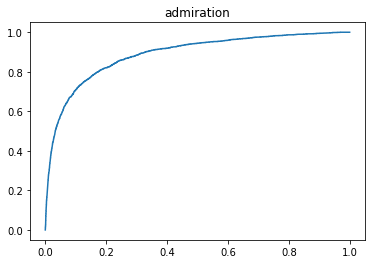

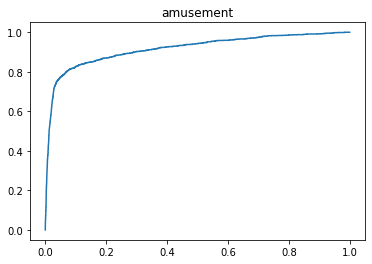

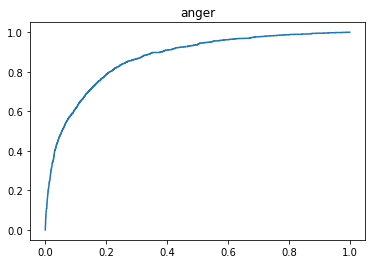

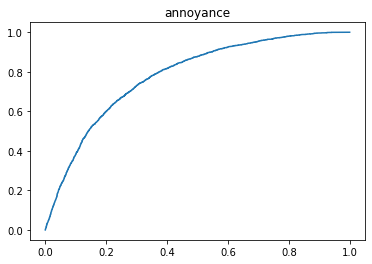

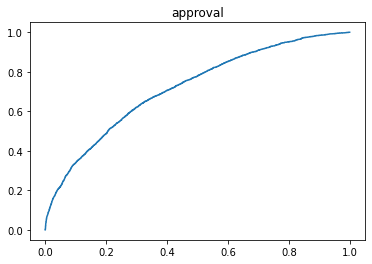

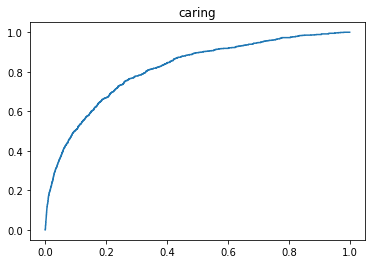

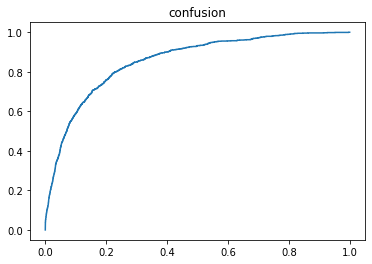

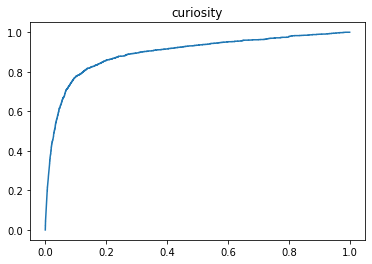

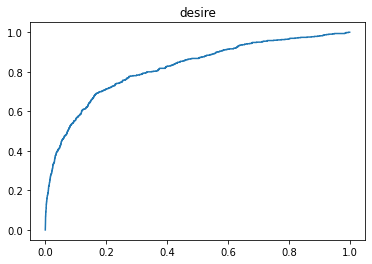

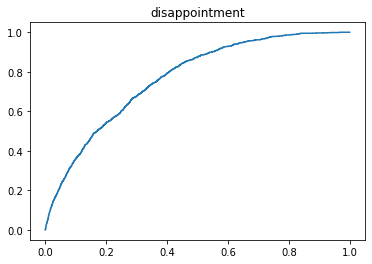

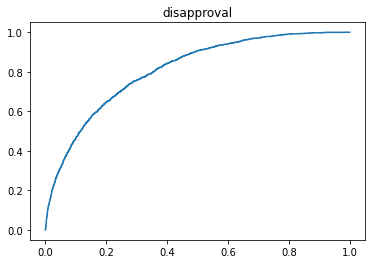

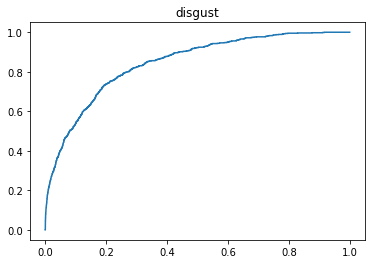

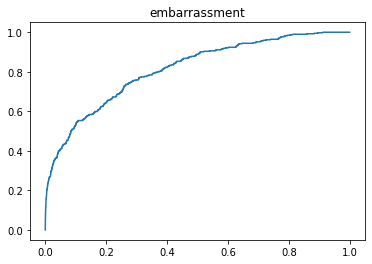

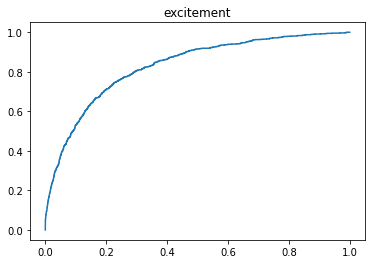

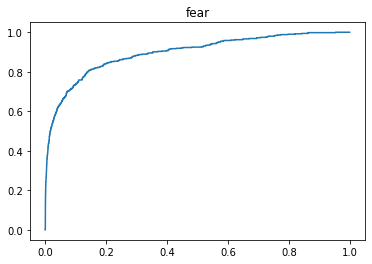

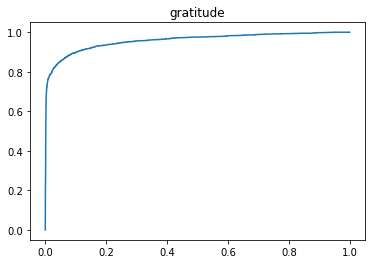

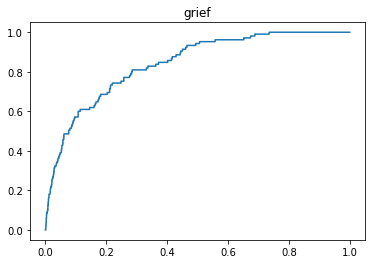

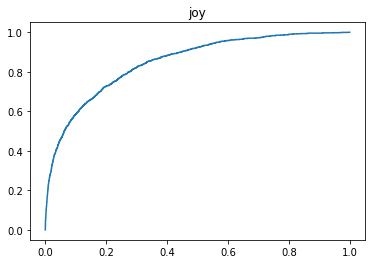

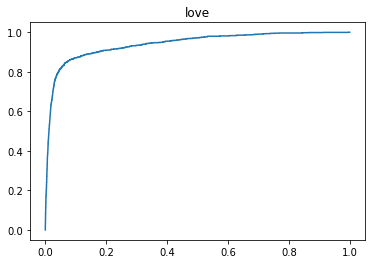

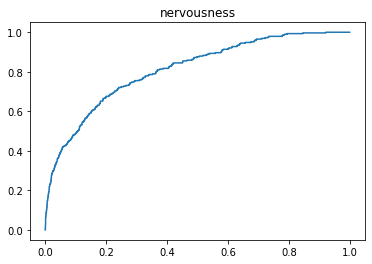

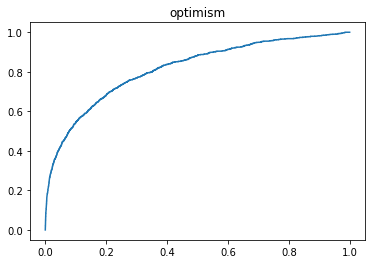

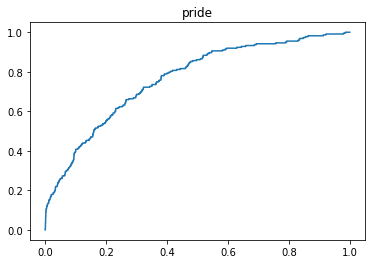

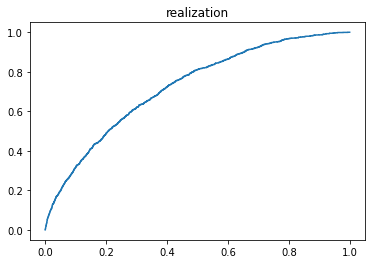

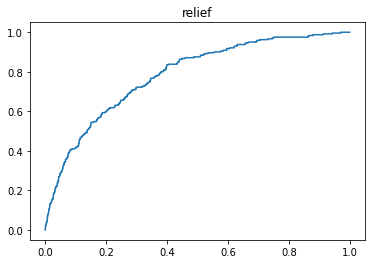

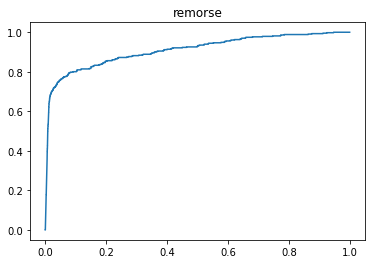

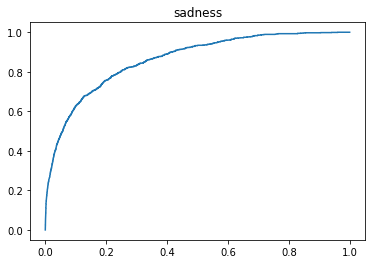

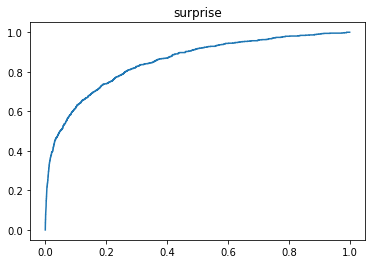

In [116]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


for i, emt in enumerate(args.emotions):
    fpr, tpr, _ = roc_curve(y_true[:, i], proba[:, i])
    plt.plot(fpr, tpr)
    plt.title(emt)
    plt.show()


In [146]:
proba_to_emotion(
    proba_on_examples([
        'fuck cloud', 
        'yeet'
    ], model, tokenizer), 
    0.4, 
    args.emotions)

[('anger', 'annoyance'), ('approval',)]

In [121]:

proba_to_emotion?


Signature: proba_to_emotion(proba, threshold, emotions)
Docstring: <no docstring>
File:      c:\users\dumps\appdata\local\temp\ipykernel_20416\2169038180.py
Type:      function
